# IOOS models

This is the first post on the series "IOOS Ocean Models IOOS."


The IOOS regional associations produces terabytes (petabytes?) of numeric ocean models results.
They can be easily found via the catalog, but reading the data is not always trivial.
Thanks to standardized metadata and grid specs one read the data and compare different models results.

The first post on this series will deal with model grids.
We have many different grid types that conform to known standards,
like UGRID and SGRID,
and some that may fall into one of those categories but do not have sufficient metadata to be easily identified.

In order to be able to extract them without worrying about the underlying nature of the grids we will use `gridgeo`.
[`gridgeo`](https://pyoceans.github.io/gridgeo/) abstracts out the grid parsing to the known standards,
and do some heuristics on non-compliant data,
to extract a [`GeoJSON`](http://geojson.org/) representation of the grid.

Here is the list of models we will work in this notebook:

In [1]:
models = {
    "DOPPIO": {
        "RA": "MARACOOS",
        "url": "http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best",
        "var": {"standard_name": "sea_water_potential_temperature"},
    },
    "NYHOPS": {
        "RA": "MARACOOS",
        "url": "http://colossus.dl.stevens-tech.edu:8080/thredds/dodsC/latest/Complete_gcmplt.nc",
        "var": {"standard_name": "sea_water_temperature"},
    },
    "NECOFS-GOM3": {
        "RA": "NERACOOS",
        "url": "http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc",
        "var": {"standard_name": "sea_water_potential_temperature"},
    },
    "NECOFS-MASSBAY": {
        "RA": "NERACOOS",
        "url": "http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc",
        "var": {"standard_name": "sea_water_potential_temperature"},
    },
    "CNAPS": {
        "RA": "SECOORA",
        "url": "http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc",
        "var": {"standard_name": "sea_water_potential_temperature"},
    },
    "CMOP-SELFE": {
        "RA": "NANOOS",
        "url": "http://amb6400b.stccmop.org:8080/thredds/dodsC/model_data/forecast",
        "var": {"standard_name": "average_sea_water_temperature"},
    },
    "OSU-ROMS": {
        "RA": "NANOOS",
        "url": "http://ona.coas.oregonstate.edu:8080/thredds/dodsC/NANOOS/OCOS",
        "var": {"standard_name": "sea_water_potential_temperature"},
    },
    "Hawaii-ROMS": {
        "RA": "PacIOOS",
        "url": "http://oos.soest.hawaii.edu/thredds/dodsC/hioos/roms_forec/hiig/ROMS_Hawaii_Regional_Ocean_Model_best.ncd",
        "var": {"standard_name": "sea_water_potential_temperature"},
    },
    "WCOFS": {
        "url": "http://opendap.co-ops.nos.noaa.gov/thredds/dodsC/WCOFS/fmrc/Aggregated_7_day_WCOFS_Fields_Forecast_best.ncd",
        "var": {"standard_name": "sea_water_temperature"},
    },
    "WestCoastUCSC": {
        "url": "http://oceanmodeling.pmc.ucsc.edu:8080/thredds/dodsC/ccsra_2016a_phys_agg_zlevs/fmrc/CCSRA_2016a_Phys_ROMS_z-level_(depth)_Aggregation_best.ncd",
        "var": {"long_name": "potential temperature"},
    },
}

Some models may have different grids for the different variables.
According to the Climate and Forecast standards we need to check the grid for a phenomena (variable).

Below we loop over the models URLs, load the `netCDF4-python` object,
and feed it to `GridGeo` checking the variable associated with temperature.

This step can take a while because we are fetching a lot of data! 

In [2]:
from gridgeo import GridGeo
from netCDF4 import Dataset

for model, value in list(models.items()):
    try:
        nc = Dataset(value["url"])
    except Exception:
        print(f'Could not download {value["url"]}')
        models.pop(model)
        continue
    models[model].update({"nc": nc})
    models[model].update({"grid": GridGeo(nc, **value["var"])})

curl error details: 


Could not download http://colossus.dl.stevens-tech.edu:8080/thredds/dodsC/latest/Complete_gcmplt.nc


curl error details: 
syntax error, unexpected $end, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: ^
curl error details: 


Could not download http://ona.coas.oregonstate.edu:8080/thredds/dodsC/NANOOS/OCOS
Could not download http://oos.soest.hawaii.edu/thredds/dodsC/hioos/roms_forec/hiig/ROMS_Hawaii_Regional_Ocean_Model_best.ncd
Could not download http://opendap.co-ops.nos.noaa.gov/thredds/dodsC/WCOFS/fmrc/Aggregated_7_day_WCOFS_Fields_Forecast_best.ncd


The cell below is a bit boring (and probably unnecessarily complex).
However, we need those functions to extract grid statistics and to easily plot them.

In [3]:
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cartopy.feature import COLORS, NaturalEarthFeature

LAND = NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="face", facecolor=COLORS["land"]
)


def plot_grid(grid, color="darkgray"):
    fig, ax = plt.subplots(
        figsize=(9, 9), subplot_kw={"projection": ccrs.PlateCarree()},
    )
    ax.add_feature(LAND, zorder=0, edgecolor="black")

    if grid.mesh in ["unknown_1d", "unknown_2d", "sgrid"]:
        if grid.mesh == "unknown_1d":
            x, y = np.meshgrid(grid.x, grid.y)
        else:
            x, y = grid.x, grid.y
        ax.plot(
            x, y, color, x.T, y.T, color, alpha=0.25,
        )
    elif grid.mesh == "ugrid":
        kw = dict(linestyle="-", alpha=0.25, color=color)
        ax.triplot(grid.triang, **kw)
    else:
        raise ValueError(f"Unrecognized grid type {grid.mesh}.")
    return fig, ax


def cftime(time):
    from netCDF4 import num2date

    times = time[:]
    calendar = getattr(time, "calendar", "standard")
    return num2date(times[0:2], time.units, calendar=calendar)


def _vlevel(var):
    try:
        vlevel = var.z_axis().shape[0]
    except ValueError:
        vlevel = None
    return vlevel


def _tstep(var):
    try:
        tstep = np.diff(cftime(var.t_axis()))[0].total_seconds()
        tstep = int(tstep)
    except ValueError:
        tstep = None
    return tstep


def _res(var):
    try:
        x = var.x_axis()[:]
        y = var.y_axis()[:]
        if x.ndim == 2 and y.ndim == 2:
            res = np.max(
                [
                    np.max(np.diff(x, axis=0)),
                    np.max(np.diff(x, axis=1)),
                    np.max(np.diff(y, axis=0)),
                    np.max(np.diff(y, axis=1)),
                ]
            )
        elif x.ndim == 1 and y.ndim == 1:
            res = np.max([np.max(np.diff(x)), np.max(np.diff(y))])
        else:
            res = "unknown"
    except ValueError:
        res = None
    return res


def get_stats(name, model):
    from gridgeo.cfvariable import CFVariable

    var = CFVariable(model["nc"], **model["var"])
    vlevel = _vlevel(var)
    tstep = _tstep(var)
    res = _res(var)

    d = {
        "RA": f'{model.get("RA", "NA")}',
        "resolution": f"{res:0.2f} meters",
        "grid type": f"{var.topology()}",
        "vertical levels": f"{vlevel}",
        "time step": f"{tstep} seconds",
    }

    df = pd.DataFrame.from_dict(d, orient="index")
    df.columns = [name]
    return df


def to_html(df):
    classes = "table table-striped table-hover table-condensed table-responsive"
    return df.to_html(classes=classes)

Now we can print the grid stats.
Note that some of the stats may be missing,
like vertical levels on surface only models,
or not represent the whole grid like grid spacing on unstructured models.

In [4]:
dfs = []
for name, model in models.items():
    table = get_stats(name, model)
    dfs.append(table)

pd.concat(dfs, axis=1)

,DOPPIO,NECOFS-GOM3,NECOFS-MASSBAY,CNAPS,CMOP-SELFE,WestCoastUCSC
RA,MARACOOS,NERACOOS,NERACOOS,SECOORA,NANOOS,NA
resolution,0.07 meters,15.86 meters,1.83 meters,0.10 meters,0.49 meters,0.10 meters
grid type,sgrid,ugrid,ugrid,unknown_2d,ugrid,unknown_2d
vertical levels,40,40,10,36,None,11
time step,86400 seconds,3712 seconds,3712 seconds,10800 seconds,None seconds,86400 seconds


We can also create static images for the full grid.

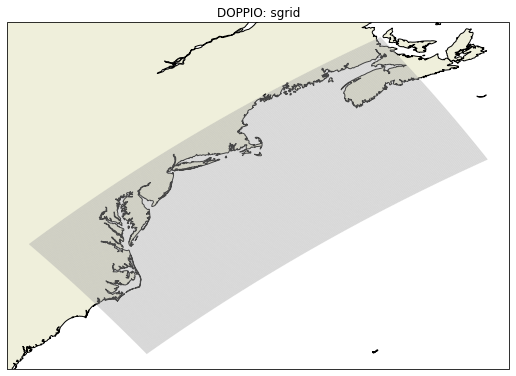

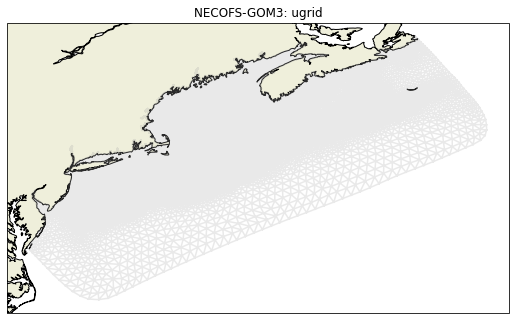

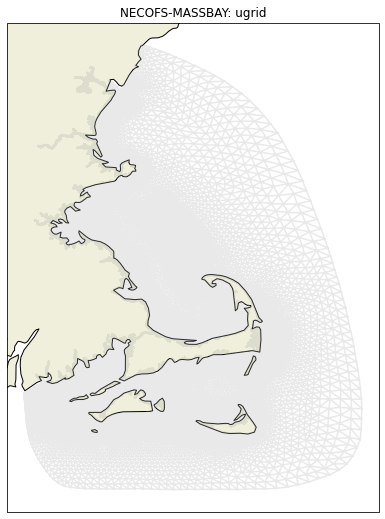

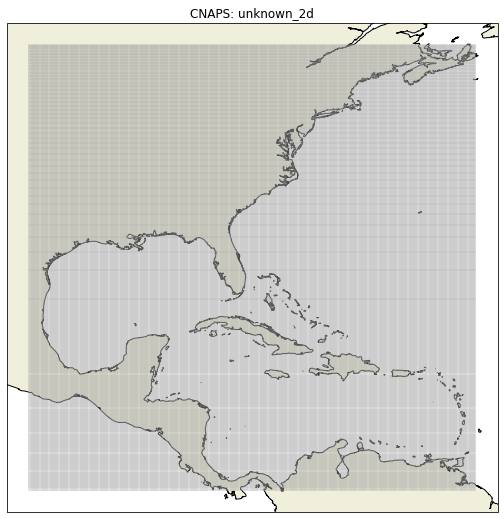

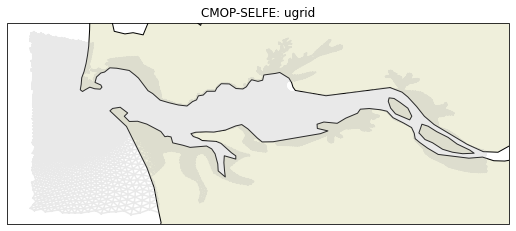

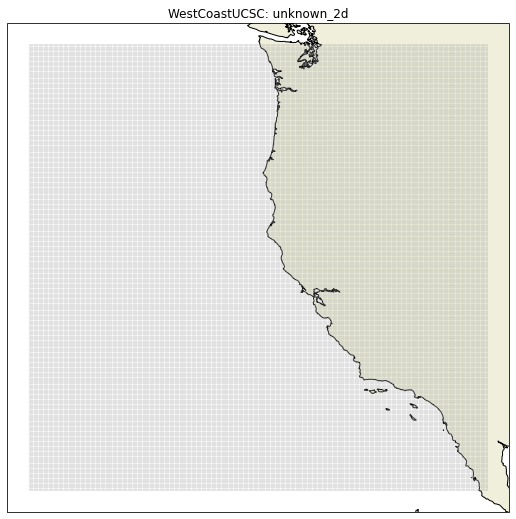

In [5]:
for name, model in models.items():
    fig, ax = plot_grid(model["grid"])
    ax.set_title(f'{name}: {model["grid"].mesh}')

However, because most grids are created in such a high resolution,
it is quite complicated to create a meaningful visualization even at lower zoom level.

To avoid that issue while still allowing for a quick domain inspection we can plot only the grid outline using `shapely` `outline` and plotting it as a GeoJSON via the `__geo_interface__`. Note that this step can be quite slow for some models due to the high resolution of the mesh.

In [6]:
import folium

m = folium.Map()

for name, model in list(models.items()):
    geojson = model["grid"].outline.__geo_interface__

    df = get_stats(name, model)
    html = to_html(df)

    gj = folium.GeoJson(geojson, name=name)
    gj.add_child(folium.Popup(html))
    gj.add_to(m)

folium.LayerControl().add_to(m)
m.fit_bounds(m.get_bounds())

m